**Importação de bibliotecas**

In [16]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

**Preparação dos dados de treinamento e validação**

In [14]:
transform = transforms.ToTensor() #define conversão imagem

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) # carrega a parte do treino
trainload = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # cria buffer dos dados

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) # carrega a validação
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)# cria buffer

100%|██████████| 9912422/9912422 [00:00<00:00, 72056582.29it/s]


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 13922042.73it/s]

Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 20091077.68it/s]


Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5171153.30it/s]


Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



**Visualização de uma imagem de exemplo**

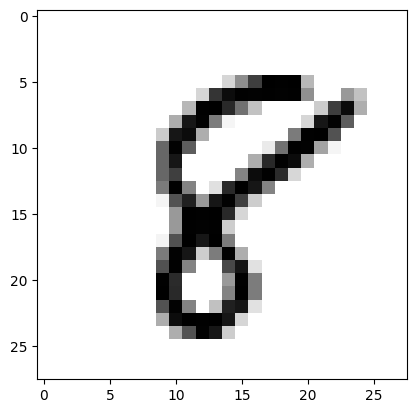

In [27]:
dataiter = iter(trainload)
imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r');

**Verificação das dimensões de uma imagem e sua etiqueta**

In [20]:
print(imagens[0].shape) #verificar dimensões do tensor
print(etiquetas[0].shape) #verificar dimensões etiqueta

torch.Size([1, 28, 28])
torch.Size([])


**Definição do modelo de rede neural**

In [21]:
class Modelo(nn.Module):
  def __init__(self):
    super(Modelo, self).__init__()
    self.linear1 = nn.Linear(28*28, 128)
    self.linear2 = nn.Linear(128, 64)
    self.linear3 = nn.Linear(64, 10)

  def forward(self, X):
    X = F.relu(self.linear1(X))
    X = F.relu(self.linear2(X))
    X = self.linear3(X)
    return F.log_softmax(X, dim=1)

**Função de treinamento do modelo**

In [22]:
def treino(modelo, trainloader, device):

  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5)
  inicio = time()

  criterio = nn.NLLLoss()
  EPOCHS = 10
  modelo.train()

  for epoch in range(EPOCHS):
    perda_acumulada = 0

    for imagens, etiquetas in trainloader:

      imagens = imagens.view(imagens.shape[0], -1)
      otimizador.zero_grad()

      output = modelo(imagens.to(device))
      perda_instantanea = criterio(output, etiquetas.to(device))

      perda_instantanea.backward()

      otimizador.step()

      perda_acumulada += perda_instantanea.item()


    else:
      print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
  print("\nTempo de treino (em minutos) = ",(time()-inicio)/60)

**Função de validação do modelo**

In [23]:
def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0, 0
  for imagens, etiquetas in valloader:
    for i in range(len(etiquetas)):
      img = imagens[i].view(1, 784)

      with torch.no_grad():
        logps = modelo(img.to(device))

      ps = torch.exp(logps)
      probab = list(ps.cpu().numpy()[0])
      etiqueta_pred = probab.index(max(probab))
      etiqueta_certa = etiquetas.numpy()[i]
      if(etiqueta_certa == etiqueta_pred):
        conta_corretas += 1
      conta_todas += 1

    print("Total de imagens testadas =", conta_todas)
    print("\nPrecisão do modelo = {}%".format(conta_corretas*100*conta_todas))

**Instanciação do Modelo e Configuração do Dispositivo**

In [24]:
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)